# ResNet

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

# Load Data

In [2]:
name = 'dataWin.csv' if os.name == 'nt' else 'data.csv'

labels = pd.read_csv(name)
labels.head()

,path,value
0,D:\Studia\MGU\Data\PS-Battles-master\originals...,0
1,D:\Studia\MGU\Data\PS-Battles-master\photoshop...,1
2,D:\Studia\MGU\Data\PS-Battles-master\photoshop...,1
3,D:\Studia\MGU\Data\PS-Battles-master\photoshop...,1
4,D:\Studia\MGU\Data\PS-Battles-master\photoshop...,1


# Show some Data

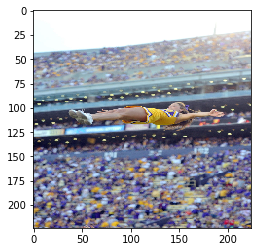

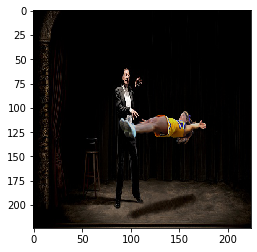

In [3]:
def get_image(path):
    img = Image.open(path)
    img = img.resize((224,224))
    img = img.convert('RGB')
    img = np.array(img)
    return img

org_row = labels[labels.value == 0].path[0]
plt.imshow(get_image(org_row))
plt.show()

ps_row = labels[labels.value == 1].path[1]
plt.imshow(get_image(ps_row))
plt.show()

# Load data to variables and split into train and test

In [51]:
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.preprocessing.image import load_img, img_to_array, array_to_img

data = []

# Load just 1/100 of data
for i in labels.path.values[::75]:
    data.append(get_image(i)) 
    
X = np.array(data, dtype=np.float32)
Y = labels.value.values[::75]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=1234123)

# Dystrybucja labelek w secie treningowym
a = pd.Series(y_train).value_counts()
print(a)
a = pd.Series(y_test).value_counts()
print(a)

1    66
0     4
dtype: int64
1    28
0     2
dtype: int64


# Notes while waitng for results

[link do artykułu](https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38)

1
(224, 224, 3)


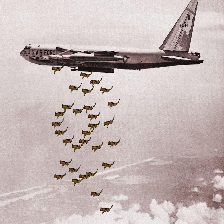

In [65]:
# Normalizacja

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train /= 255 
X_test /= 255 

print(y_train[0]) 

# visualize a sample image 
print(X_train[0].shape) 
array_to_img(X_train[0])

In [66]:
from keras.models import Model
import keras

IMG_WIDTH=224
IMG_HEIGHT=224

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)

restnet = Model(restnet.input, output=output)

# Zamrożenie wag
for layer in restnet.layers:
    layer.trainable = False
    
restnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

d:\programs\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  if sys.path[0] == '':


In [67]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(restnet)

model.add(Dense(512, activation='relu', input_dim=(224, 224)))
model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 75,231,617
Trainable params: 51,643,905
Non-trainable params: 23,587,712
_________________________________

In [71]:
history = model.fit(X_train, y_train, steps_per_epoch=10, epochs=100, verbose=1)

Epoch 1/10
2/2 [==============================] - 25s 12s/step - loss: 0.5654 - accuracy: 0.9429
Epoch 2/10
2/2 [==============================] - 25s 12s/step - loss: 0.4797 - accuracy: 0.9429
Epoch 3/10
2/2 [==============================] - 25s 13s/step - loss: 0.5612 - accuracy: 0.9429
Epoch 4/10
2/2 [==============================] - 25s 12s/step - loss: 0.5318 - accuracy: 0.9429
Epoch 5/10
2/2 [==============================] - 25s 12s/step - loss: 0.3463 - accuracy: 0.9429
Epoch 6/10
2/2 [==============================] - 25s 13s/step - loss: 0.3982 - accuracy: 0.9429
Epoch 7/10
2/2 [==============================] - 25s 13s/step - loss: 0.2886 - accuracy: 0.9286
Epoch 8/10
2/2 [==============================] - 25s 12s/step - loss: 0.3388 - accuracy: 0.9000
Epoch 9/10
2/2 [==============================] - 25s 13s/step - loss: 0.4375 - accuracy: 0.8643
Epoch 10/10
2/2 [==============================] - 25s 12s/step - loss: 0.4093 - accuracy: 0.8643


In [73]:
model.save('test_resnet50.h5')

In [92]:
org = get_image('D:\Studia\MGU\Data\PS-Battles-master\originals\yipf7.jpg')
ps = get_image('D:\Studia\MGU\Data\PS-Battles-master\photoshops\yipf7\c5vytne_0.jpg')

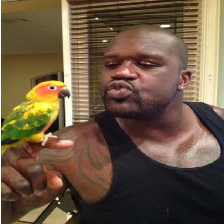

In [93]:
array_to_img(org)

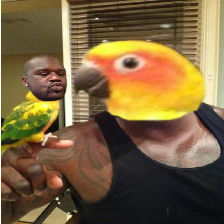

In [94]:
array_to_img(ps)

In [95]:
org = np.array(org, dtype=np.float32)
print(org.shape)
org = np.expand_dims(org, 0)
print(org.shape)

ps = np.array(ps, dtype=np.float32)
print(ps.shape)
ps = np.expand_dims(ps, 0)
print(ps.shape)

(224, 224, 3)
(1, 224, 224, 3)
(224, 224, 3)
(1, 224, 224, 3)


In [96]:
model.predict(org, verbose=1)

1/1 [==============================] - 0s 309ms/step


array([[0.45409128]], dtype=float32)

In [97]:
model.predict(ps, verbose=1)

1/1 [==============================] - 0s 310ms/step


array([[0.11175603]], dtype=float32)